In [15]:
#conda update --all
#%pip install gensim
#%pip install nltk
#%pip install termcolor
#%pip install wordcloud

**Komentari**

Ostavljat ću komentare dok punimo bilježnicu da znamo u svakom trenutku što je što. Kasnije možemo lagano ih samo obrisati za završnu verziju.

Zasad ubacujem podatke u bilježnicu i malo ću poraditi s njima te ih rasporediti lijepo u tablice da možemo lagano raditi s njima što želimo.

## OPIS PROBLEMA
***

U ovoj bilježnici istraživat ćemo *natural language processing* (NLP) analizirajući 10000 tweetova podijeljenih u dvije kategorije. 
Tweetovi su grupirani s obzirom na one čija je tematika neka prirodna ili socijalna katastrofa i one koji to nisu. 

Prilikom analize koristit ćemo bazu podatka dostupnu na platformi *Kaggle* gdje je rješenje ovoga problema moguće podijeliti sa ostalim korisnicima platforme. Upravo je ondje tema i osmišljena pod nazivom **Natural Language Processing with Disaster Tweets**. Mnoge zanimljive i praktične metode rješavanja ovog zadatka dostupne su na *https://www.kaggle.com/c/nlp-getting-started*.

Kao primjer promotrimo sljedeće tweetove:

***
    TWEET 1:  That concert last night was FIRE!
    TWEET 2:  There's a huge forest fire in Malibu right now!!! 
***

Iako oba tweeta koriste riječ *fire* samo drugi uistinu govori o stvarnoj, u ovom slučaju prirodnoj, nepogodi, odnosno katastrofi.
Možemo li istrenirati model koji će znati razlikovati i pravilno klasificirati ove dvije vrste poruka? Pokušajmo saznati!


## EKSPLORATORNA ANALIZA PROBLEMA
***

### Podaci
***

Dodajemo sve biblioteke koje će nam trebati (možda treba pozvati %pip install za slučaj da na računalu nisu instalirane):

In [14]:
import nltk
nltk.download('stopwords')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop = set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from termcolor import colored
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict
import wordcloud

Skidanje podataka s našeg repozitorija na GitHub-u i njihovo lokalno spremanje:

In [16]:
def skini(url: str, datoteka: str):
    import urllib.request as rq, pathlib
    with rq.urlopen(url) as konekcija:
        pathlib.Path(datoteka).write_bytes(konekcija.read())
        
test_podaci = 'https://raw.githubusercontent.com/jbrigljevic/str_uc/main/Podaci/test.csv'
train_podaci = 'https://raw.githubusercontent.com/jbrigljevic/str_uc/main/Podaci/train.csv'
skini(test_podaci, 'test_podaci.csv')
skini(train_podaci, 'train_podaci.csv')

Učitavanje u Dataframe:

In [17]:
df_test = pd.read_csv('test_podaci.csv')
df_train = pd.read_csv('train_podaci.csv')

**Promotrimo oblik i formu učitanih podataka za treniranje pa zatim podataka za testiranje na nekoliko konkretnih primjera:**

In [18]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [19]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [20]:
print(colored('\nU tablici podataka za treniranje nalazi se {} redaka i {} stupaca.'.format(df_train.shape[0], df_train.shape[1]), 'red', attrs = ['bold']))
print(colored('U tablici podataka za testiranje nalaze se {} retka i {} stupca.'.format(df_test.shape[0], df_test.shape[1]), 'red', attrs = ['bold']))


U tablici podataka za treniranje nalazi se 7613 redaka i 5 stupaca.
U tablici podataka za testiranje nalaze se 3263 retka i 4 stupca.


***
Zaključujemo da spremljeni podaci imaju tri svojstva podložna detaljnijoj analizi: ***keyword, location*** i ***text***.

Spremit ćemo ID retka za krajnju analizu te integrirati dane podatke u jedinstveni DataFrame. Međutim, prije nego što to učinimo promotrimo koja bi od navedenih svojstava bilo uistinu korisno zadržati u novonastalom DataFrame-u. 
***

Za početak promatramo koliko podataka iz skupa za treniranje, a koliko iz testnog skupa nema zadano svojstvo *location*:

In [21]:
print(colored(df_train['location'].isnull().value_counts(), 'green'));

False    5080
True     2533
Name: location, dtype: int64


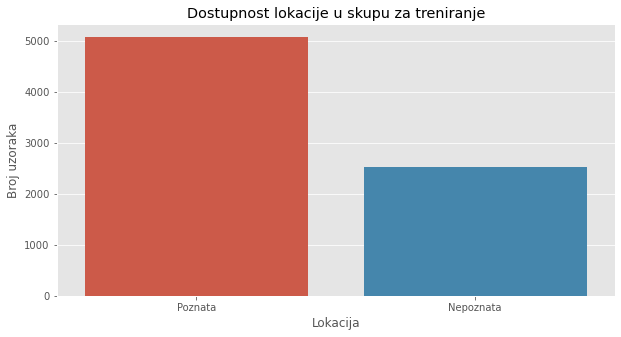

In [22]:
fig, ax = plt.subplots(figsize = (10, 5))

graph = sns.countplot(x = df_train['location'].isnull().index, data = df_train['location'].isnull())

graph.set(xticklabels = ['Poznata', 'Nepoznata'])
plt.gca().set_ylabel('Broj uzoraka')
plt.gca().set_xlabel('Lokacija')
plt.title('Dostupnost lokacije u skupu za treniranje')

plt.show(graph)

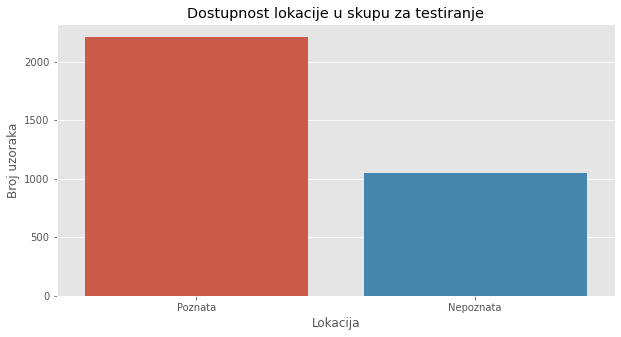

In [23]:
fig, ax = plt.subplots(figsize = (10, 5))

graph = sns.countplot(x = df_test['location'].isnull().index, data = df_train['location'].isnull())

graph.set(xticklabels = ['Poznata', 'Nepoznata'])
plt.gca().set_ylabel('Broj uzoraka')
plt.gca().set_xlabel('Lokacija')
plt.title('Dostupnost lokacije u skupu za testiranje')

plt.show(graph)

**Zaključujemo da u treniranju modela nema smisla promatrati svojstvo *location* budući da je kod prevelikog udjela danih podataka to svojstvo nepoznato.** Stoga pri integriranju testnih podataka i onih za treniranje modela, izostavljamo informaciju o lokaciji tweeta. 

Nastavimo našu analizu promatranjem dostupnosti svojstva keyword:

In [24]:
print(colored(df_train['keyword'].isnull().value_counts(), 'green'));

False    7552
True       61
Name: keyword, dtype: int64


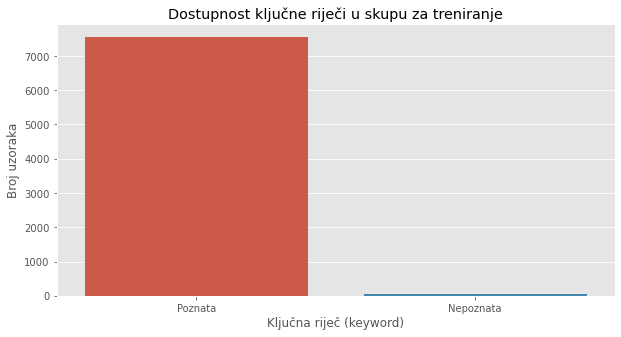

In [25]:
fig, ax = plt.subplots(figsize = (10, 5))

graph = sns.countplot(x = df_train['keyword'].isnull().index, data = df_train['keyword'].isnull())

graph.set(xticklabels = ['Poznata', 'Nepoznata'])
plt.gca().set_ylabel('Broj uzoraka')
plt.gca().set_xlabel('Ključna riječ (keyword)')
plt.title('Dostupnost ključne riječi u skupu za treniranje')

plt.show(graph)

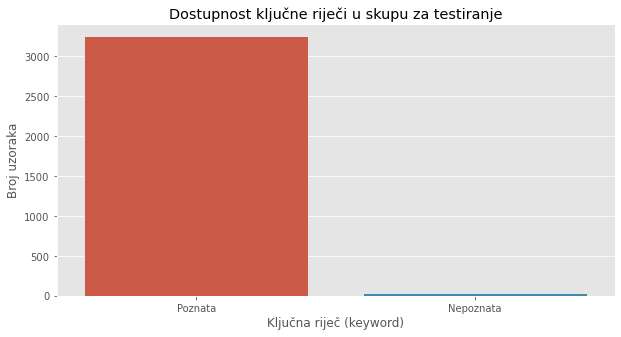

In [26]:
fig, ax = plt.subplots(figsize = (10, 5))

graph = sns.countplot(x = df_test['keyword'].isnull().index, data = df_test['keyword'].isnull())

graph.set(xticklabels = ['Poznata', 'Nepoznata'])
plt.gca().set_ylabel('Broj uzoraka')
plt.gca().set_xlabel('Ključna riječ (keyword)')
plt.title('Dostupnost ključne riječi u skupu za testiranje')

plt.show(graph)

Dolazimo do saznanja da je ključna riječ, odnosno svojstvo *keyword*, poznato u gotovo svim uzorcima pa ćemo ga uključiti i u naše integrirane podatke. Spremimo ključne riječi u skupove *skup_keyword_test* i *skup_keyword_train* koje ćemo koristiti pri detaljnijoj analizi ovog svojstva u dostupnim podacima.

In [27]:
skup_keyword_test = {keyword for keyword in df_test['keyword']}
skup_keyword_train = {keyword for keyword in df_train['keyword']}

Započnimo sada s već prije spomenutim spajanjem podataka.

In [28]:
#spremamo ID
test_id = df_test['id']

#dropamo lokaciju i id iz train i test data framea
columns = {'id', 'location'}
df_train = df_train.drop(columns = columns)
df_test = df_test.drop(columns = columns)

#popunimo nepoznate keywords s 'unknown'
df_train['keyword'] = df_train['keyword'].fillna('unknown')
df_test['keyword'] = df_test['keyword'].fillna('unknown')

#stvaramo strukture potrebne za kasniju analizu podataka na osnovu kljucne rijeci
df_keyword_train = df_train;
df_keyword_test = df_test;

#dodajemo keyword u tekst tweeta
df_train['text'] = df_train['text'] + ' ' + df_train['keyword']
df_test['text'] = df_test['text'] + ' ' + df_test['keyword']

#dropamo keyword iz df_train i df_test
columns = {'keyword'}
df_train = df_train.drop(columns = columns)
df_test = df_test.drop(columns = columns)

#spojimo podatke u jedan data frame
df_total = df_train.append(df_test)

print(colored('\nU novonastalom data frameu pod nazivom df_total nalazi se {} zapisa, odnosno tweetova organiziranih na sljedeći način: '.format(df_total.shape[0]), 'red', attrs = ['bold']))
df_total.head()


U novonastalom data frameu pod nazivom df_total nalazi se 10876 zapisa, odnosno tweetova organiziranih na sljedeći način: 


C:\Users\Juraj\AppData\Local\Temp\ipykernel_25808\3297989805.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_total = df_train.append(df_test)


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1.0
1,Forest fire near La Ronge Sask. Canada unknown,1.0
2,All residents asked to 'shelter in place' are ...,1.0
3,"13,000 people receive #wildfires evacuation or...",1.0
4,Just got sent this photo from Ruby #Alaska as ...,1.0



Prije nego započnemo s detaljnijom analizom podataka, promotrimo distribuciju podataka za treniranje u klase *Katastrofa* i *Nije katastrofa*.

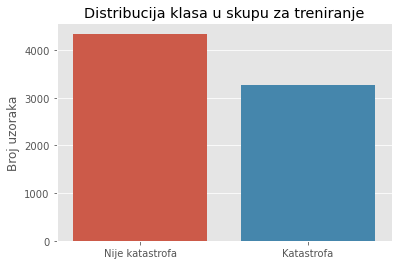

In [29]:
x = df_train.target.value_counts()
sns.barplot(x = x.index, y = x)

plt.gca().set_ylabel('Broj uzoraka');
plt.title('Distribucija klasa u skupu za treniranje');
plt.gca().set(xticklabels = ['Nije katastrofa', 'Katastrofa']);

Zaključujemo da je u našem skupu za treniranje više tweetova koji ne govore o pravoj katastrofi, nego onih koji opisuju stvarnu tragičnu ili opasnu situaciju.
***

### Dodavanje osnovnih svojstava
***

Radi jednostavnije analize obilježja i strukture tweetova koji govore o katastrofama, novonastalom skupu podataka dodajemo nova, zanimljiva i praktična svojstva. 

In [30]:
#stvaramo stupac za broj riječi u pojedinom tweetu
df_total['word count'] = df_total['text'].apply(lambda x: len(x.split()))

#sliceamo da bismo ažurirali train set
df_train = df_total[:len(df_train)]

df_train.head()

,text,target,word count
0,Our Deeds are the Reason of this #earthquake M...,1.0,14
1,Forest fire near La Ronge Sask. Canada unknown,1.0,8
2,All residents asked to 'shelter in place' are ...,1.0,23
3,"13,000 people receive #wildfires evacuation or...",1.0,9
4,Just got sent this photo from Ruby #Alaska as ...,1.0,17


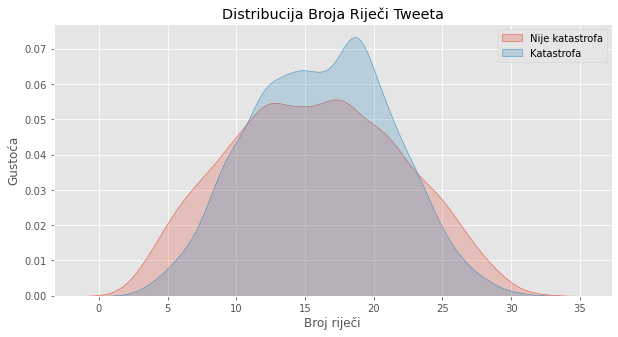

In [31]:
#definiramo subplot da bismo grafove smjestili jedan do drugoga
fig, ax = plt.subplots(figsize = ( 10, 5))

#kreiramo grafove
sns.kdeplot(df_train['word count'][df_train['target'] == 0], shade = True, label = 'Nije katastrofa', legend = True)
sns.kdeplot(df_train['word count'][df_train['target'] == 1], shade = True, label = 'Katastrofa', legend = True)

#naslov grafa
plt.title('Distribucija Broja Riječi Tweeta')
plt.gca().set_ylabel('Gustoća')
plt.gca().set_xlabel('Broj riječi')

plt.legend()
plt.show()

Slijede skupovi ključnih riječi i lokacija te mapa s textovima samih tweetova i pripadajuće oznake.

In [32]:
#stvori stupac za broj znakova u tweetu
df_total['character count'] = df_total['text'].apply(lambda x: len(x))

#sliceamo da bismo ažurirali train set 
df_train = df_total[:len(df_train)]

df_train.head()

,text,target,word count,character count
0,Our Deeds are the Reason of this #earthquake M...,1.0,14,77
1,Forest fire near La Ronge Sask. Canada unknown,1.0,8,46
2,All residents asked to 'shelter in place' are ...,1.0,23,141
3,"13,000 people receive #wildfires evacuation or...",1.0,9,73
4,Just got sent this photo from Ruby #Alaska as ...,1.0,17,96


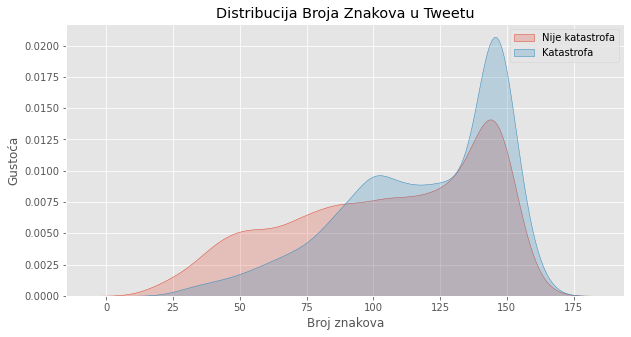

In [33]:
#definiramo subplot da bismo grafove vidjeli skupa
fig, ax = plt.subplots(figsize = (10, 5))

#kreiramo grafove
sns.kdeplot(df_train['character count'][df_train['target'] == 0], shade = True, label = 'Nije katastrofa')
sns.kdeplot(df_train['character count'][df_train['target'] == 1], shade = True, label = 'Katastrofa')

#naslov grafa
plt.title('Distribucija Broja Znakova u Tweetu')
plt.gca().set_ylabel('Gustoća')
plt.gca().set_xlabel('Broj znakova')

plt.legend()
plt.show()

**Promatrajući dobiveni graf zaključujemo da tek mali broj tweetova o stvarnoj katastrofi sadrži manje od 50 znakova, dok većina sadrži više od 125 znakova.**

In [34]:
#definiramo funkciju za pronalazak prosjecne duljine rijeci
def prosjecna_duljina_rijeci(x):
    x = x.split()
    return np.mean([len(i) for i in x])

#primjenjujemo funkciju na stupac 'text'
df_total['average word length'] = df_total['text'].apply(prosjecna_duljina_rijeci)

#sliceamo da bismo ažurirali train set
df_train = df_total[:len(df_train)]

df_train.head()

,text,target,word count,character count,average word length
0,Our Deeds are the Reason of this #earthquake M...,1.0,14,77,4.571429
1,Forest fire near La Ronge Sask. Canada unknown,1.0,8,46,4.875000
2,All residents asked to 'shelter in place' are ...,1.0,23,141,5.173913
3,"13,000 people receive #wildfires evacuation or...",1.0,9,73,7.111111
4,Just got sent this photo from Ruby #Alaska as ...,1.0,17,96,4.647059


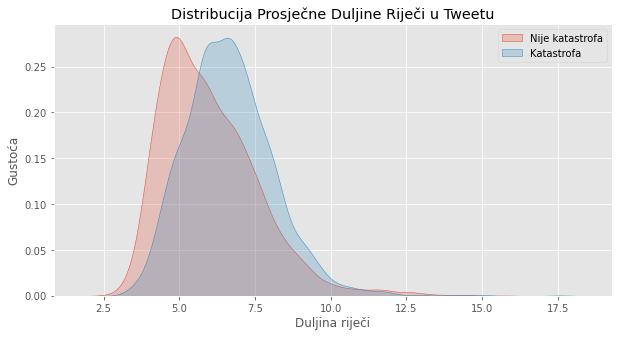

In [35]:
#definiramo subplot da bismo grafove vidjeli skupa
fig, ax = plt.subplots(figsize = (10, 5))

#kreiramo graf
sns.kdeplot(df_train['average word length'][df_train['target'] == 0], shade = True, label = 'Nije katastrofa')
sns.kdeplot(df_train['average word length'][df_train['target'] == 1], shade = True, label = 'Katastrofa')

#naslov grafa
plt.title('Distribucija Prosječne Duljine Riječi u Tweetu')
plt.gca().set_ylabel('Gustoća')
plt.gca().set_xlabel('Duljina riječi')

plt.legend()
plt.show()

In [36]:
#broj jedinstvenih riječi
df_total['unique word count'] = df_total['text'].apply(lambda x: len(set(x.split())))

#brojimo stopwords odnosno riječi koje znatno ne prinose značenju rečenice
df_total['stopword count'] = df_total['text'].apply(lambda x: len([i for i in x.lower().split() if i in wordcloud.STOPWORDS]))

#omjer stopwords/total words
df_total['stopword ratio'] = df_total['stopword count'] / df_total['word count']

#brojimo interpunkcije
df_total['punctuation count'] = df_total['text'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))

#sliceamo da bismo ažurirali train set
df_train = df_total[:len(df_train)]

df_train.head()

,text,target,word count,character count,average word length,unique word count,stopword count,stopword ratio,punctuation count
0,Our Deeds are the Reason of this #earthquake M...,1.0,14,77,4.571429,14,6,0.428571,1
1,Forest fire near La Ronge Sask. Canada unknown,1.0,8,46,4.875000,8,0,0.000000,1
2,All residents asked to 'shelter in place' are ...,1.0,23,141,5.173913,21,11,0.478261,3
3,"13,000 people receive #wildfires evacuation or...",1.0,9,73,7.111111,9,1,0.111111,2
4,Just got sent this photo from Ruby #Alaska as ...,1.0,17,96,4.647059,16,7,0.411765,2


Kreirajmo sada grafove distribucije prethodno definiranih svojstava.

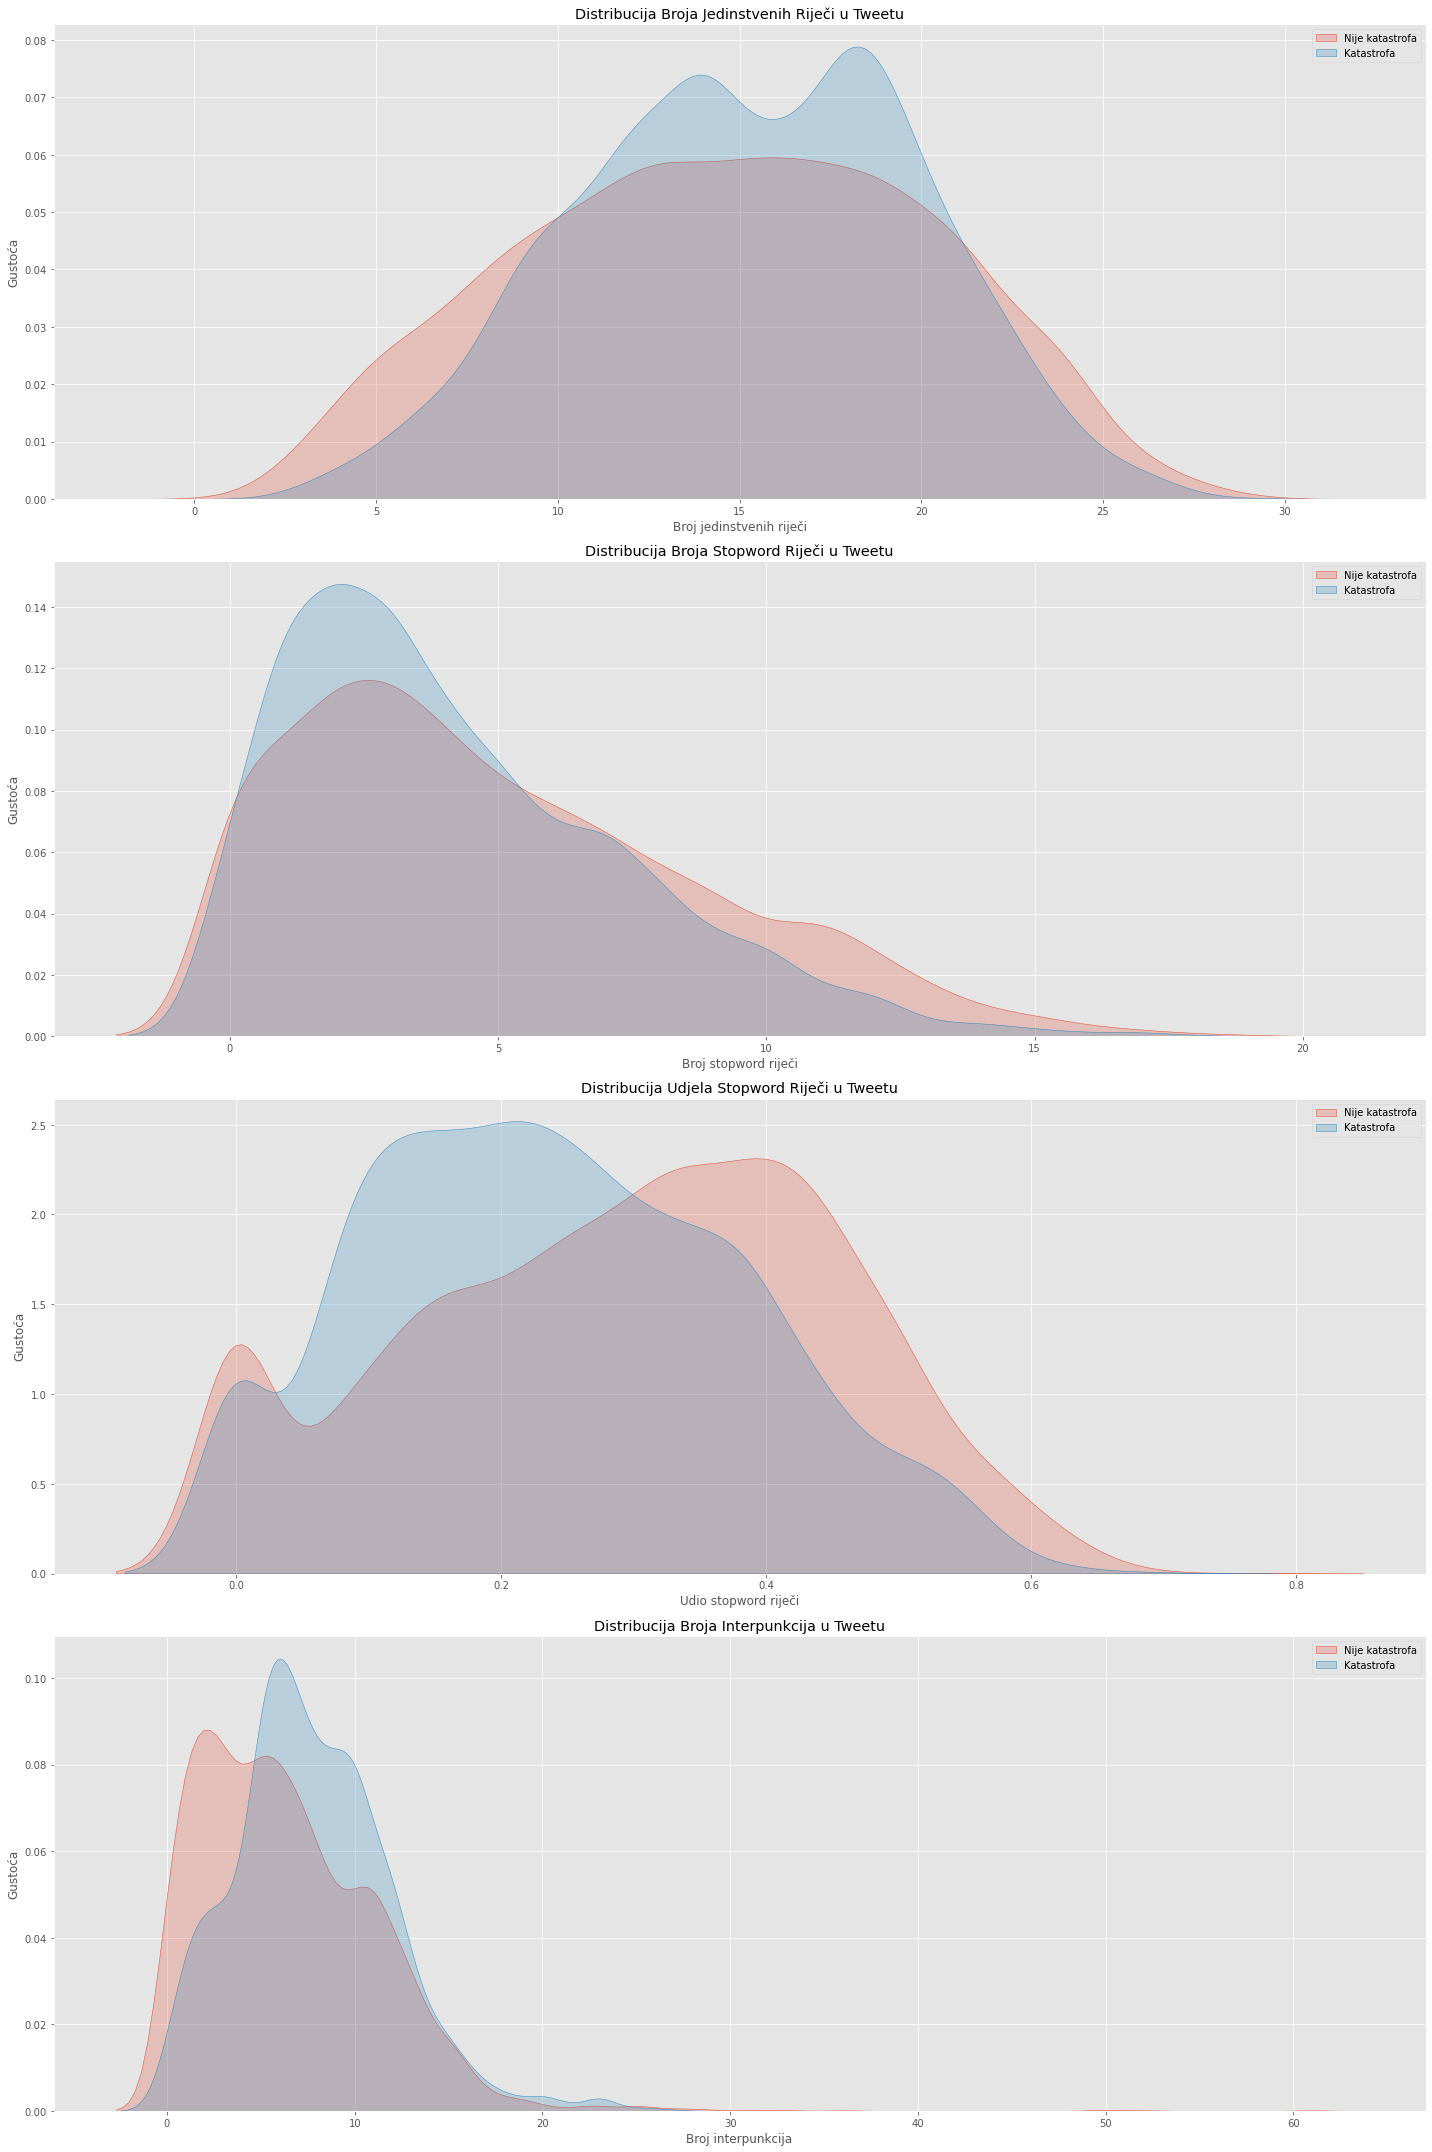

In [37]:
katastrofe = df_train['target'] == 1

fig, axes = plt.subplots(4, figsize = (20, 30))

#broj jedinstvenih rijeci
graph1 = sns.kdeplot(df_train.loc[~katastrofe]['unique word count'], shade = True, label = 'Nije katastrofa', ax = axes[0])
graph1 = sns.kdeplot(df_train.loc[katastrofe]['unique word count'], shade = True, label = 'Katastrofa', ax = axes[0])
graph1.set_title('Distribucija Broja Jedinstvenih Riječi u Tweetu')
graph1.set_ylabel('Gustoća')
graph1.set_xlabel('Broj jedinstvenih riječi')
graph1.legend()


#stopword count
graph2 = sns.kdeplot(df_train.loc[~katastrofe]['stopword count'], shade = True, label = 'Nije katastrofa', ax = axes[1])
graph2 = sns.kdeplot(df_train.loc[katastrofe]['stopword count'], shade = True, label = 'Katastrofa', ax = axes[1])
graph2.set_title('Distribucija Broja Stopword Riječi u Tweetu')
graph2.set_ylabel('Gustoća')
graph2.set_xlabel('Broj stopword riječi')
graph2.legend()

#stopword omjer
graph3 = sns.kdeplot(df_train.loc[~katastrofe]['stopword ratio'], shade = True, label = 'Nije katastrofa', ax = axes[2])
graph3 = sns.kdeplot(df_train.loc[katastrofe]['stopword ratio'], shade = True, label = 'Katastrofa', ax = axes[2])
graph3.set_title('Distribucija Udjela Stopword Riječi u Tweetu')
graph3.set_ylabel('Gustoća')
graph3.set_xlabel('Udio stopword riječi')
graph3.legend()

#broj interpunkcijskih znakova
graph4 = sns.kdeplot(df_train.loc[~katastrofe]['punctuation count'], shade = True, label = 'Nije katastrofa', ax = axes[3])
graph4 = sns.kdeplot(df_train.loc[katastrofe]['punctuation count'], shade = True, label = 'Katastrofa', ax = axes[3])
graph4.set_title('Distribucija Broja Interpunkcija u Tweetu')
graph4.set_ylabel('Gustoća')
graph4.set_xlabel('Broj interpunkcija')
graph4.legend()

fig.tight_layout()
plt.show()

Promatrajući grafove možemo naslutiti da će tweetovi koji govore o stvarnoj katastrofi sadržavati manji broj i udio *stopword* riječi, odnosno riječi koje svojim sadržajem ne pridonose znatno značenju rečenice, odnosno tweeta. Također, takvi će tweetovi sadržavati više interpunkcijskih znakova, što bismo intuitivno mogli i pretpostaviti, budući da se pri razmjenjivanju šokantnih vijesti i poruka obilno te višestruko koriste interpunkcije poput *!* i *?*.

Započnimo sada analizu podataka s obzirom na ključnu riječ koji sadrže.

### Ključna riječ
---

Koristit ćemo prije definirane *df_keyword_train* i *df_keyword_test* pa za početak promotrimo njihovu formu, odnosno strukturu:

In [38]:
df_keyword_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   keyword  7613 non-null   object
 1   text     7613 non-null   object
 2   target   7613 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 178.6+ KB


In [39]:
df_keyword_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   keyword  3263 non-null   object
 1   text     3263 non-null   object
dtypes: object(2)
memory usage: 51.1+ KB


Pogledajmo sada frekvencije ključnih riječi koje se spominju u danim podacima:

In [46]:
def graf_br_kljucnih(df):
    count_keyword_positive = {}
    count_keyword_negative = {}
    for keyword in df['keyword'].unique():
        if(not pd.isna(keyword)):
            if(keyword in df[df['target'] == 1]['keyword'].unique()):
                count_keyword_positive[keyword] = df[df['target'] == 1]['keyword'].value_counts()[keyword]
            else:
                count_keyword_positive[keyword] = 0
                
            if(keyword in df[df['target'] == 0]['keyword'].unique()):
                count_keyword_negative[keyword] = df[df['target'] == 0]['keyword'].value_counts()[keyword]
            else:
                count_keyword_negative[keyword] = 0
            
    count_keyword_positive = {k: v for k, v in sorted(count_keyword_positive.items(), key=lambda item: item[1])}

    count_keyword_negative_sorted = {}
    for keyword in count_keyword_positive:
        count_keyword_negative_sorted[keyword] = count_keyword_negative[keyword]
        
    fig, ax = plt.subplots(figsize = (12, 200))
    b1 = ax.barh(list(count_keyword_positive.keys()), list(count_keyword_positive.values()), color = 'orange')
    b2 = ax.barh(list(count_keyword_negative_sorted.keys()), list(count_keyword_negative_sorted.values()),
            left = list(count_keyword_positive.values()))
    
    for index, value in enumerate(list(count_keyword_positive.values())):
        if(value > 2):
            plt.text(value, index, str(value) + ' / ' + str(list(count_keyword_negative_sorted.values())[index]),
                 ha = 'right', va = 'center')
            
        elif(value == 2):
            plt.text(value + 1, index, str(value) + ' / ' + str(list(count_keyword_negative_sorted.values())[index]),
                 ha = 'right', va = 'center')
            
        elif(value == 1):
            plt.text(value + 2.5, index, str(value) + ' / ' + str(list(count_keyword_negative_sorted.values())[index]),
                 ha = 'right', va = 'center')
            
        else:
            plt.text(value + 3, index, str(value) + ' / ' + str(list(count_keyword_negative_sorted.values())[index]),
                 ha = 'right', va = 'center')
    
    plt.legend([b1, b2], ['Pozitivni', 'Negativni'], title = 'Oznaka', loc = 'upper right')
    plt.title('Broj ključnih riječi ovisno o oznaci')
    plt.margins(y=0.001)
    plt.show()

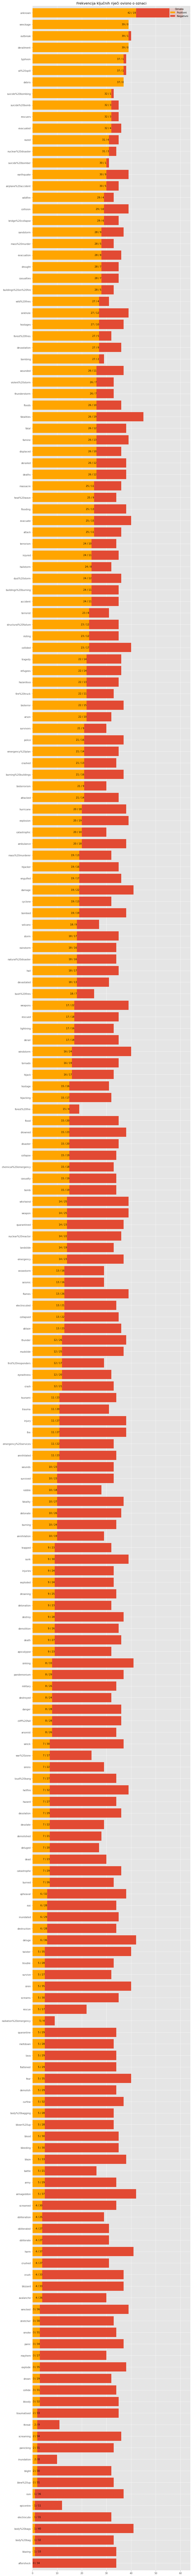

In [45]:
graf_br_kljucnih(df_keyword_train)